---
title: Stripe A/B Test - Fee Reduction

author: Diana Munteanu, Nimisha Thomas, Amaury Hellebuyck

region: EU

date: 2021-11-25

summary: In this experiment we evaluate the results of reducing the Stripe top-up fee from 3% to either 2% or 1%. Results show that markets with 1% fee have significantly higher conversion rates and topup volumes compared to control group, while markets with 2% fee do not have significantly different results from the control.

tags: top-up, stripe, activation, volumes, engagement, fee, feature adoption, card top-up

link: https://docs.google.com/presentation/d/16MkglG8lB5t9gOHgiMmFyF2zmNnnNS0_HwWyQleOdGs/edit?usp=sharing

research_type: Data Deep Dives

---

#### Import packages

In [ ]:
cd /app/

/app


In [ ]:
!pip install plotly
!pip install seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.datalib_database import df_to_db, df_from_sql
from utils.datalib_database import df_from_sql

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import plotly.express as px
from plotly import graph_objects as go
from scipy.stats import ttest_ind, mannwhitneyu, beta, wilcoxon

import seaborn as sns

sns.set(color_codes=True)

### Contents 
- <a href='#Background'>Background</a>
- <a href='#design'>Experimental Design</a>
- <a href='#sample'>Sample Size</a>
- <a href='#analysis'>Results Analysis</a>

### Background  <a id='Background'></a> 
There is a minimum of €20 and a maximum of €450 per Stripe top up. The monthly limit for the customer is €450. Every first top up is free of charge and every recurring top up after that is being charged with a 3% fee no matter which top up method is being used.

Feature adoption is different across markets because of the varying pricing sensitivity and competitive landscapes. Currently, the assumption is that the fee is too high and prevents customers from conducting a second top up. With this test we attempt to understand whether a price reduction can potentially boost the adoption rate as well as the incoming volumes. 

Top-up methods available: Card & Wallet (all markets), GiroPay (DEU), iDEAL (NLD), Bancontact (BEL), EPS (AUT) 

### Experimental Design <a id='design'></a> 

Users will be randomly split into two groups: 

- Control group that will see the usual fee of 3%.

- Test group that will see an alternative fee (this can be either 2% or 1% depending on the fraud and risk level in each market). 

Users in the test group will see diferent fees, based on their country_tnc_legal. E.g. FRA, NLD, BEL - 2%; DEU, ITA, ESP, AUT - 1% 

**Selection criteria:**
- Users who performed their only Stripe top-up in the past 12 months, excluding the month before the test (September '21) 
- Is not a fraudster  

An infocard will be presented to both groups with a reminder about the top-up method availability and the existing fee for each group. (See example below) 
The fee can be also seen as soon as the user lands on the first screen of the top-up, i.e. 'Amount Input'. 
![Infocard](Infocard_stripe.jpeg)

### Success measures 

- Funnel conversion rate (from first screen to confirmation screen) 
- Volume per user 
- Total revenue
- Infocard CTR 


### Experiment Analysis 
The experiment ran between October 4th and November 4th 2021.  

### Sample Size <a id='sample'></a> 

In [ ]:
users_lists = [
    "DEU_stripetest_290921.csv",
    "FRA_stripetest_290921.csv",
    "ITA_stripetest_290921.csv",
    "ESP_stripetest_290921.csv",
    "AUT_stripetest_290921.csv",
    "BEL_stripetest_290921.csv",
    "NLD_stripetest_290921.csv",
]

In [ ]:
df_users = []
for item in users_lists:
    df_temp = pd.read_csv(item, index_col=0)
    df_users.append(df_temp)

df = pd.concat(df_users, axis=0, ignore_index=True)

In [ ]:
germany = pd.read_csv("DEU_stripetest_290921.csv", index_col=0)

In [ ]:
df

In [ ]:
df.index.name = "id"
df.index = df.index + 1

In [ ]:
df = df.reset_index()

In [ ]:
# Create table in dev schema
# df_to_db("redshiftreader", df, "stripe_test", chunksize=5000, schema = 'dev')

### Median days between first Stripe top-up and subsequent top-ups


In [ ]:
query = """
with total as (
select user_created, txn_ts, 
       case when payment_scheme = 'SEPA' and txn_type = 'Credit Transfer' then 'SEPA'
            when payment_scheme = 'SEPA INSTANT' then 'SEPA INSTANT'
            when txn_type = 'MoneyBeam Transfer' then 'Moneybeam'
            when txn_type = 'Cash26' then 'Cash26'
            when txn_type = 'Stripe' then 'Stripe'
            when payment_scheme = 'SWIFT' then 'SWIFT' else 'Other' end as cat,
row_number() over(partition by user_created order by txn_ts) as rn
from dbt.zrh_transactions 
join dbt.zrh_users using (user_created)
where txn_group = 'Money In' and user_created >= '2021-01-01' 
and txn_type not in ('Spaces', 'Fees/Internal') and type not in ('DR', 'PF', 'WU')
and is_fraudster is false
) 
,first_topup as 
(
select distinct user_created from total 
where rn=1 and cat = 'Stripe') 

select a.* 
from total a
inner join first_topup b on a.user_created = b.user_created 

"""

stripe = df_from_sql("redshiftreader", query)
stripe

In [ ]:
stripe["shifted_txn_ts"] = stripe.groupby("user_created")["txn_ts"].shift(1)

In [ ]:
stripe.loc[stripe["shifted_txn_ts"].isna(), "shifted_txn_ts"] = stripe["txn_ts"]

In [ ]:
stripe["diff_ts"] = (stripe["txn_ts"] - stripe["shifted_txn_ts"]).apply(
    lambda x: x.days
)

In [ ]:
stripe["cumulative_diff"] = stripe.groupby("user_created")["diff_ts"].cumsum()

In [ ]:
stripe.groupby("rn")["cumulative_diff"].median()
# Users who start out with Stripe make their second top-up after a median of 9 days
# and their third top-up after a median of 21 days

In [ ]:
# Distribution for no. of days passed until the user made their third top-up
fix, ax = plt.subplots(figsize=(10, 7))
stripe[stripe["rn"] == 2].hist(column="cumulative_diff", bins=20, ax=ax)
plt.xticks(range(0, 180, 15))
plt.xlim((0, 180))
plt.show()

**Key takeaway: 
Users who start out with Stripe make their second top-up after a median of 9 days and their third top-up after a median of 21 days**

## Results Analysis <a id='analysis'></a> 

In [ ]:
test_query = """with x as (select collector_date, case when se_value is not null then se_value
                            when se_label is null then 10
                            when se_label = 'payment_confirmed' then 30
                            when se_label = 'payment_failed' then 31
                            when se_label = 'payment_success' then 40 else 10 end as se_value, 
                            dev.stripe_test.country_tnc_legal, is_treatment, 
                            count(distinct dbt.snowplow.user_created) as users
from dbt.snowplow
join dbt.zrh_users using (user_created)
join dev.stripe_test using (user_id)
where se_action in
('OverdraftFeeIC.topup.stripe.card', 'unknown.topup.stripe.card', 'CHATBOT.topup.stripe.card','pushnotif.topup.stripe.card', 'Onboarding.topup.stripe.card', '[home].topup.stripe.card',
'actions.topup.stripe.card', 'actions.topup.stripe.wallet','CHATBOT.topup.stripe.wallet', 'unknown.topup.stripe.wallet', 'topup.topup.stripe.wallet',
'Onboarding.topup.stripe.wallet', '[home].topup.stripe.wallet', 'pushnotif.topup.stripe.wallet',
'Onboarding.topup.stripe.eps', 'actions.topup.stripe.eps', '.topup.stripe.eps', 'unknown.topup.stripe.eps',
'Onboarding.topup.stripe.ideal', 'actions.topup.stripe.ideal', '.topup.stripe.ideal', 'unknown.topup.stripe.ideal',
'Onboarding.topup.stripe.giropay', 'actions.topup.stripe.giropay', '.topup.stripe.giropay', 'unknown.topup.stripe.giropay',
'Onboarding.topup.stripe.bancontact', 'actions.topup.stripe.bancontact', '.topup.stripe.bancontact', 'unknown.topup.stripe.bancontact', 'topup_stripe_details_screen')
and collector_tstamp >= '2021-10-04' and collector_tstamp < '2021-11-05'
group by 1,2,3,4 
)

select collector_date, is_treatment, country_tnc_legal as market, se_value, users
from x 
where se_value in (10,30,40) 
order by 1,2,3,4"""

In [92]:
query_stripe = """with x as (
                select collector_tstamp, 
                       case when se_value is not null then se_value
                            when se_label is null then 10
                            when se_label = 'payment_confirmed' then 30
                            when se_label = 'payment_failed' then 31
                            when se_label = 'payment_success' then 40 else 10 end as se_value, 
                            is_treatment, 
                            dev.stripe_test.country_tnc_legal as market, 
                            dev.stripe_test.user_id
from dbt.snowplow
join dbt.zrh_users using (user_created)
join dev.stripe_test using (user_id)
where se_action in
('OverdraftFeeIC.topup.stripe.card', 'unknown.topup.stripe.card', 'CHATBOT.topup.stripe.card','pushnotif.topup.stripe.card', 'Onboarding.topup.stripe.card', '[home].topup.stripe.card',
'actions.topup.stripe.card', 'actions.topup.stripe.wallet','CHATBOT.topup.stripe.wallet', 'unknown.topup.stripe.wallet', 'topup.topup.stripe.wallet',
'Onboarding.topup.stripe.wallet', '[home].topup.stripe.wallet', 'pushnotif.topup.stripe.wallet',
'Onboarding.topup.stripe.eps', 'actions.topup.stripe.eps', '.topup.stripe.eps', 'unknown.topup.stripe.eps',
'Onboarding.topup.stripe.ideal', 'actions.topup.stripe.ideal', '.topup.stripe.ideal', 'unknown.topup.stripe.ideal',
'Onboarding.topup.stripe.giropay', 'actions.topup.stripe.giropay', '.topup.stripe.giropay', 'unknown.topup.stripe.giropay',
'Onboarding.topup.stripe.bancontact', 'actions.topup.stripe.bancontact', '.topup.stripe.bancontact', 'unknown.topup.stripe.bancontact', 'topup_stripe_details_screen')
and collector_tstamp >= '2021-10-04' and collector_tstamp < '2021-11-05'
)
 
select user_id, is_treatment, market, min(case when se_value = 10 then collector_tstamp end) as start_date, 
min(case when se_value = 30 then collector_tstamp end) as confirm_date
from x 
group by 1,2,3 
"""

In [93]:
test_df = df_from_sql("redshiftreader", query_stripe)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20211201T124916", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "004c6496-6350-4bb0-8a86-782331c29c78", "hostname": "172.19.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 28.8262, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20211201T124945", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "004c6496-6350-4bb0-8a86-782331c29c78", "hostname": "172.19.0.4"}


In [94]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11638 entries, 0 to 11637
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       11638 non-null  object        
 1   is_treatment  11638 non-null  bool          
 2   market        11638 non-null  object        
 3   start_date    11636 non-null  datetime64[ns]
 4   confirm_date  3978 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 375.2+ KB


## I. Statistical analysis - Z-test significance for each market based on a discrete variable (conversion rate)

### Germany

In [114]:
deu_results = (
    test_df.loc[test_df.market.str.contains("DEU")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
deu_results

,is_treatment,start_date,confirm_date
0,False,948,227
1,True,993,291


In [115]:
deu_results["conversion"] = deu_results["confirm_date"] / deu_results["start_date"]

conversion_control = deu_results.loc[
    deu_results.is_treatment == False
].conversion.values[0]
conversion_variant = deu_results.loc[
    deu_results.is_treatment == True
].conversion.values[0]

# calculate zscore
n_variant = deu_results.loc[deu_results.is_treatment == True]["start_date"].values[0]
n_control = deu_results.loc[deu_results.is_treatment == False]["start_date"].values[0]
success_variant = deu_results[deu_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = deu_results[deu_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [116]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.0037856924159145365 , reject the null hypothesis, there are significant differences between these two groups


### Austria

In [110]:
aut_results = (
    test_df.loc[test_df.market.str.contains("AUT")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
aut_results

,is_treatment,start_date,confirm_date
0,False,382,91
1,True,379,122


In [111]:
# calculate zscore
n_variant = aut_results.loc[aut_results.is_treatment == True]["start_date"].values[0]
n_control = aut_results.loc[aut_results.is_treatment == False]["start_date"].values[0]
success_variant = aut_results[aut_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = aut_results[aut_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [112]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.00507858152779928 , reject the null hypothesis, there are significant differences between these two groups


### France

In [107]:
fra_results = (
    test_df.loc[test_df.market.str.contains("FRA")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
fra_results

,is_treatment,start_date,confirm_date
0,False,897,316
1,True,880,324


In [108]:
# calculate zscore
n_variant = fra_results.loc[fra_results.is_treatment == True]["start_date"].values[0]
n_control = fra_results.loc[fra_results.is_treatment == False]["start_date"].values[0]
success_variant = fra_results[fra_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = fra_results[fra_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [109]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.24262126648693982 , fail to reject the null hypothesis, there are no significant differences between these two groups


### Italy

In [104]:
ita_results = (
    test_df.loc[test_df.market.str.contains("ITA")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
ita_results

,is_treatment,start_date,confirm_date
0,False,876,196
1,True,909,256


In [105]:
# calculate zscore
n_variant = ita_results.loc[ita_results.is_treatment == True]["start_date"].values[0]
n_control = ita_results.loc[ita_results.is_treatment == False]["start_date"].values[0]
success_variant = ita_results[ita_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = ita_results[ita_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [106]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.0024510964058991015 , reject the null hypothesis, there are significant differences between these two groups


### Spain

In [98]:
esp_results = (
    test_df.loc[test_df.market.str.contains("ITA")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
esp_results

,is_treatment,start_date,confirm_date
0,False,876,196
1,True,909,256


In [99]:
# calculate zscore
n_variant = esp_results.loc[esp_results.is_treatment == True]["start_date"].values[0]
n_control = esp_results.loc[esp_results.is_treatment == False]["start_date"].values[0]
success_variant = esp_results[esp_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = esp_results[esp_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [100]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.0024510964058991015 , reject the null hypothesis, there are significant differences between these two groups


### Netherlands

In [95]:
nld_results = (
    test_df.loc[test_df.market.str.contains("NLD")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
nld_results

,is_treatment,start_date,confirm_date
0,False,1359,652
1,True,1430,713


In [96]:
# calculate zscore
n_variant = nld_results.loc[nld_results.is_treatment == True]["start_date"].values[0]
n_control = nld_results.loc[nld_results.is_treatment == False]["start_date"].values[0]
success_variant = nld_results[nld_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = nld_results[nld_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [97]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.15994016759820878 , fail to reject the null hypothesis, there are no significant differences between these two groups


### Belgium


In [101]:
bel_results = (
    test_df.loc[test_df.market.str.contains("BEL")]
    .groupby("is_treatment")[["start_date", "confirm_date"]]
    .count()
    .reset_index()
)
bel_results

,is_treatment,start_date,confirm_date
0,False,519,198
1,True,503,212


In [102]:
# calculate zscore
n_variant = bel_results.loc[bel_results.is_treatment == True]["start_date"].values[0]
n_control = bel_results.loc[bel_results.is_treatment == False]["start_date"].values[0]
success_variant = bel_results[bel_results.is_treatment == True]["confirm_date"].values[
    0
]
success_control = bel_results[bel_results.is_treatment == False]["confirm_date"].values[
    0
]
p_variant = success_variant / n_variant
p_control = success_control / n_control
p = np.mean([p_variant, p_control])
z = (p_variant - p_control) / np.sqrt(p * (1 - p) * (1 / n_variant + 1 / n_control))

In [103]:
# calculate the p_value
p_values = stats.norm.sf(abs(z))
p_values
if p_values > 0.05:
    print(
        "P value equals",
        p_values,
        ", fail to reject the null hypothesis, there are no significant differences between these two groups",
    )
else:
    print(
        "P value equals",
        p_values,
        ", reject the null hypothesis, there are significant differences between these two groups",
    )

P value equals 0.09626650940031473 , fail to reject the null hypothesis, there are no significant differences between these two groups


## II. Volume per user : Applying Mann Whiteney Test for a continous, not normally distributed variable

In [ ]:
vol_user = """
select
pt.user_id, is_treatment, country_tnc_legal, sum(pt.amount) as volume
from pt_charge pt
inner join dev.stripe_test dev on dev.user_id = pt.user_id
where pt.status = 'succeeded' and pt.created >='2021-10-04' and pt.created < '2021-11-05'
group by 1,2,3 """

In [ ]:
volume_df = df_from_sql("redshiftreader", vol_user)

In [ ]:
volume_df

### Plotting the histogram for volumes

In [ ]:
volume_df[volume_df.country_tnc_legal.str.contains("DEU")].hist(
    column="volume", by="is_treatment", bins=5, sharex=True, sharey=True
)

##### Germany

In [ ]:
# Subsetting for DEU:
control_deu = volume_df[
    (volume_df.country_tnc_legal.str.contains("DEU"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_deu = volume_df[
    (volume_df.country_tnc_legal.str.contains("DEU")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_deu, treatment_deu, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

In [ ]:
boxplot = volume_df[volume_df.country_tnc_legal.str.contains("DEU")].boxplot(
    column="volume", by="is_treatment", figsize=(8, 6), grid=False
)
boxplot.set_title("")
boxplot.set_ylabel("Volume")

##### Austria

In [ ]:
# Subsetting for AUT:
control_aut = volume_df[
    (volume_df.country_tnc_legal.str.contains("AUT"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_aut = volume_df[
    (volume_df.country_tnc_legal.str.contains("AUT")) & (volume_df.is_treatment == True)
]["volume"]

mannwhitneyu(control_aut, treatment_aut, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

##### Italy

In [ ]:
# Subsetting for ITA:
control_ita = volume_df[
    (volume_df.country_tnc_legal.str.contains("ITA"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_ita = volume_df[
    (volume_df.country_tnc_legal.str.contains("ITA")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_ita, treatment_ita, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

##### Spain 

In [ ]:
# Subsetting for ESP:
control_esp = volume_df[
    (volume_df.country_tnc_legal.str.contains("ESP"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_esp = volume_df[
    (volume_df.country_tnc_legal.str.contains("ESP")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_esp, treatment_esp, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

##### France

In [ ]:
# Subsetting for FRA:
control_fra = volume_df[
    (volume_df.country_tnc_legal.str.contains("FRA"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_fra = volume_df[
    (volume_df.country_tnc_legal.str.contains("FRA")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_fra, treatment_fra, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

#### Netherlands

In [ ]:
# Subsetting for NLD:
control_nld = volume_df[
    (volume_df.country_tnc_legal.str.contains("NLD"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_nld = volume_df[
    (volume_df.country_tnc_legal.str.contains("NLD")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_nld, treatment_nld, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

##### Belgium 

In [ ]:
# Subsetting for BEL:
control_bel = volume_df[
    (volume_df.country_tnc_legal.str.contains("BEL"))
    & (volume_df.is_treatment == False)
]["volume"]
treatment_bel = volume_df[
    (volume_df.country_tnc_legal.str.contains("BEL")) & (volume_df.is_treatment == True)
]["volume"]

stat, p = mannwhitneyu(control_bel, treatment_bel, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

## III. Revenue (PnL) per Converted User
checking whether the total PnL revenue of test users is less than that of the control users

In [7]:
pnl_converted = """with sample as 
(select user_id, user_created, is_treatment, dev.country_tnc_legal 
from dev.stripe_test dev
inner join cmd_users cmd on dev.user_id = cmd.id 
)
,pnl as (
select user_created, value 
from dbt.ucm_pnl ucm
left join dbt.ucm_mapping m on ucm.label = m.label 
where revenue_cost = 'Revenue' and month in ('2021-10', '2021-11')
)
,test as (
select distinct pt.user_id, user_created, is_treatment, country_tnc_legal 
from pt_charge pt 
inner join sample on pt.user_id = sample.user_id
where pt.status = 'succeeded' and pt.created between '2021-10-04' and '2021-11-04' --test duration
)
select country_tnc_legal, is_treatment, t.user_created, sum(a.value)/100.0 as revenue 
from pnl a
inner join test t on t.user_created = a.user_created 
group by 1,2,3 
"""

pnl_df = df_from_sql("redshiftreader", pnl_converted)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20211201T120522", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "004c6496-6350-4bb0-8a86-782331c29c78", "hostname": "172.19.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 37.3153, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20211201T120600", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "004c6496-6350-4bb0-8a86-782331c29c78", "hostname": "172.19.0.4"}


In [14]:
pnl_df  # checking revenue per user

,country_tnc_legal,is_treatment,user_created,revenue
0,FRA,True,2020-11-11 14:49:03.753250,29.277383
1,DEU,False,2020-10-05 13:53:25.478156,78.278495
2,DEU,False,2021-04-29 10:09:53.354496,29.670964
3,ITA,True,2020-06-05 12:28:45.528795,23.224623
4,ITA,True,2018-03-05 23:28:42.962272,14.585810
...,...,...,...,...
3463,DEU,True,2021-02-11 21:31:49.429838,0.508171
3464,DEU,True,2019-08-19 12:45:47.664488,0.418613
3465,FRA,True,2021-08-23 12:22:48.857404,2.570394
3466,NLD,True,2021-08-30 07:36:12.385169,24.038264


In [ ]:
agg_pnl = (
    pnl_df.groupby(["is_treatment", "country_tnc_legal"])["revenue"].sum().reset_index()
)

## Visualising total PnL revenue by market

<AxesSubplot:title={'center':'Germany'}, xlabel='is_treatment'>

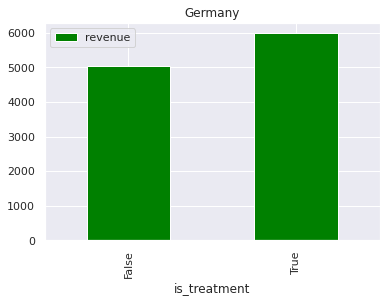

In [78]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("DEU")].plot.bar(
    x="is_treatment", color="green", title="Germany"
)

<AxesSubplot:title={'center':'Austria'}, xlabel='is_treatment'>

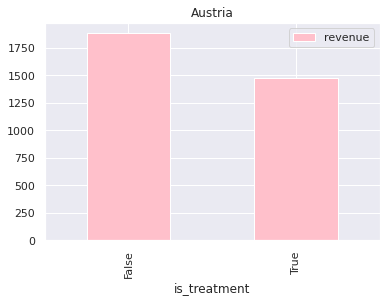

In [80]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("AUT")].plot.bar(
    x="is_treatment", color="pink", title="Austria"
)

<AxesSubplot:title={'center':'Italy'}, xlabel='is_treatment'>

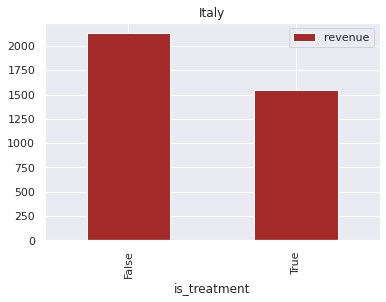

In [82]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("ITA")].plot.bar(
    x="is_treatment", color="brown", title="Italy"
)

<AxesSubplot:title={'center':'Spain'}, xlabel='is_treatment'>

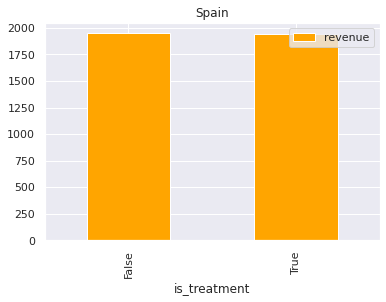

In [84]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("ESP")].plot.bar(
    x="is_treatment", color="orange", title="Spain"
)

<AxesSubplot:title={'center':'France'}, xlabel='is_treatment'>

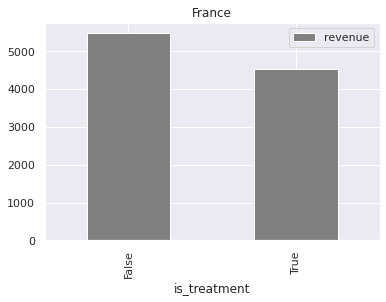

In [86]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("FRA")].plot.bar(
    x="is_treatment", color="grey", title="France"
)

<AxesSubplot:title={'center':'Netherlands'}, xlabel='is_treatment'>

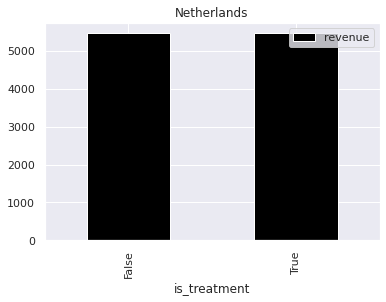

In [88]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("NLD")].plot.bar(
    x="is_treatment", color="black", title="Netherlands"
)

<AxesSubplot:title={'center':'Belgium'}, xlabel='is_treatment'>

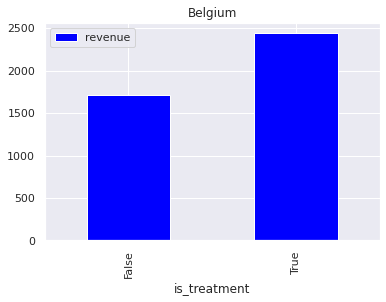

In [90]:
agg_pnl[agg_pnl.country_tnc_legal.str.contains("BEL")].plot.bar(
    x="is_treatment", color="blue", title="Belgium"
)

### Applying Mann Whitney Test for significance for each market  

### Germany

In [10]:
# Subsetting for DEU:
control_pnl_deu = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("DEU")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_deu = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("DEU")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_deu, treatment_pnl_deu, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9978571135398957 , fail to reject the null hypothesis


### Austria

In [15]:
# Subsetting for AUT:
control_pnl_aut = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("AUT")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_aut = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("AUT")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_aut, treatment_pnl_aut, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9755553587465137 , fail to reject the null hypothesis


### Italy

In [69]:
# Subsetting for ITA:
control_pnl_ita = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("ITA")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_ita = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("ITA")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_ita, treatment_pnl_ita, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9998809490730903 , fail to reject the null hypothesis


### Spain

In [71]:
# Subsetting for ESP:
control_pnl_esp = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("ESP")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_esp = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("ESP")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_esp, treatment_pnl_esp, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9993476412654858 , fail to reject the null hypothesis


### France

In [72]:
# Subsetting for FRA:
control_pnl_fra = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("FRA")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_fra = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("FRA")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_fra, treatment_pnl_fra, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9981469169466031 , fail to reject the null hypothesis


### Netherlands

In [75]:
# Subsetting for NLD:
control_pnl_nld = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("NLD")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_nld = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("NLD")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_nld, treatment_pnl_nld, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.9996768312280053 , fail to reject the null hypothesis


### Belgium

In [76]:
# Subsetting for BEL:
control_pnl_bel = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("BEL")) & (pnl_df.is_treatment == False)
]["revenue"]
treatment_pnl_bel = pnl_df[
    (pnl_df.country_tnc_legal.str.contains("BEL")) & (pnl_df.is_treatment == True)
]["revenue"]

stat, p = mannwhitneyu(control_pnl_bel, treatment_pnl_bel, alternative="less")

if p > 0.05:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", fail to reject the null hypothesis",
    )
else:
    print(
        "Mann-Whitney U test for null hypothesis treatment <= control is",
        p,
        ", reject the null hypothesis",
    )

Mann-Whitney U test for null hypothesis treatment <= control is 0.4590244533167393 , fail to reject the null hypothesis


### Key takeaway: PnL revenue per user is not significantly higher in any of the tested markets 

## Multivariate testing: no infocard/ infocard 3%/ infocard 1% 

In [ ]:
no_infocard_users = """with final as 
(select pt.user_id, b.country_tnc_legal, is_mau, count(*) as ct, min(pt.created) as first_topup
from pt_charge pt 
inner join dbt.zrh_users b on pt.user_id = b.user_id 
left join pt_dispute di on pt.stripe_id = di.charge_id 
left join dev.stripe_test dev on pt.user_id = dev.user_id and dev.user_id is null 
where pt.status = 'succeeded' and b.country_tnc_legal in ('DEU', 'FRA', 'ITA', 'ESP', 'AUT', 'NLD', 'BEL') 
and closed_at is null and is_fraudster is false and is_blacklisted is false 
and di.charge_id is null and pt.created < '2021-10-04'
group by 1,2,3
having ct = 1 
)

select country_tnc_legal, user_id, first_topup, is_mau 
from final 
where first_topup >= date_trunc('month', current_date - interval '1 year') --and first_topup < date_trunc('month', current_date)
"""
no_info_df = df_from_sql("redshiftreader", no_infocard_users)

## Looking into the users' behaviour before the test

### How many users have done self-transfers with SEPA CT before the test? 

In [ ]:
self_transfers = """with self_transfer as (
    select cmd.id as user_id,
           etl.created,
           etl.partner_name,
           cmd.first_name,
           cmd.last_name,
           etl.reference_text,
           case
               when (lower(etl.partner_name::text) like '%' || lower(cmd.first_name::text) || '%') then 1
               else 0 end as self
    from etl_reporting.zr_transaction etl
             inner join cr_user_account cr on etl.account_id = cr.account_id
             inner join etl_reporting.cmd_users cmd on cmd.user_created = cr.user_created
    where etl.type = 'CT'
      and etl.payment_scheme = 'SEPA'
      and etl.created >= '2021-09-01'
      and etl.created < '2021-10-04'
      and lower(etl.partner_name::text) like '%' || lower(cmd.last_name::text) || '%'
)
, stripe as (
    select  distinct pt.user_id, case when is_treatment is true then 'test' else 'control' end as cat
from pt_charge pt
inner join dev.stripe_test dev on pt.user_id = dev.user_id
where pt.status = 'succeeded' and pt.created between '2021-10-04' and '2021-11-04'
)
, final as
    (
   select distinct user_id
        from self_transfer
        where self = 1
    )

, final_final as
    (select stripe.user_id, stripe.cat, case when final.user_id is not null then 1 end as self_transferred
     from stripe
              left join final on stripe.user_id = final.user_id
    )

select cat, count(user_id) as users, sum(self_transferred) as total_self, total_self::float/users as percentage
from final_final
group by 1
order by 1"""
self_df = df_from_sql("redshiftreader", self_transfers)

In [ ]:
self_transfers_allyear = """with self_transfer as (
    select cmd.id as user_id,
           etl.created,
           etl.partner_name,
           cmd.first_name,
           cmd.last_name,
           etl.reference_text,
           case
               when (lower(etl.partner_name::text) like '%' || lower(cmd.first_name::text) || '%') then 1
               else 0 end as self
    from etl_reporting.zr_transaction etl
             inner join cr_user_account cr on etl.account_id = cr.account_id
             inner join etl_reporting.cmd_users cmd on cmd.user_created = cr.user_created
    where etl.type = 'CT'
      and etl.payment_scheme = 'SEPA'
      and etl.created >= '2021-01-01'
      and etl.created < '2021-10-04'
      and lower(etl.partner_name::text) like '%' || lower(cmd.last_name::text) || '%'
)
, stripe as (
    select  distinct pt.user_id, case when is_treatment is true then 'test' else 'control' end as cat, 
    dev.country_tnc_legal 
from pt_charge pt
inner join dev.stripe_test dev on pt.user_id = dev.user_id
where pt.status = 'succeeded' and pt.created between '2021-10-04' and '2021-11-04'
)
, final as
    (
   select distinct user_id
        from self_transfer
        where self = 1
    )

, final_final as
    (select stripe.user_id, stripe.cat, case when final.user_id is not null then 1 end as self_transferred
     from stripe
              left join final on stripe.user_id = final.user_id
    )

select cat, count(user_id) as users, sum(self_transferred) as total_self, total_self::float/users as percentage
from final_final
group by 1
order by 1"""
self_allyear_df = df_from_sql("redshiftreader", self_transfers_allyear)

In [ ]:
self_df

In [ ]:
ax = self_df.plot.bar(x="cat", y="percentage", rot=1, color="pink")
plt.title("Percentage of users with self_transfers one month before the test")

#### Key takeaway: 13% of  users did a self-transfer during the month of September 

In [ ]:
self_allyear_df

In [ ]:
ax = self_allyear_df.plot.bar(x="cat", y="percentage", rot=1, color="brown")
plt.title("Percentage of users with self_transfers one year before the test")

#### Key takeaway: 28% of users did a self-transfer during 2021

### How many users have funded their accounts with SEPA CT before the test? 

In [ ]:
sepa_ct = """with self_transfer as (
    select distinct cmd.id as user_id
    from etl_reporting.zr_transaction etl
             inner join cr_user_account cr on etl.account_id = cr.account_id
             inner join etl_reporting.cmd_users cmd on cmd.user_created = cr.user_created
    where etl.type = 'CT'
      and etl.payment_scheme = 'SEPA'
      and etl.created >= '2021-09-01'
      and etl.created < '2021-10-04'
)
, stripe as (
    select  distinct pt.user_id, case when is_treatment is true then 'test' else 'control' end as cat, 
    dev.country_tnc_legal
from pt_charge pt
inner join dev.stripe_test dev on pt.user_id = dev.user_id
where pt.status = 'succeeded' and pt.created between '2021-10-04' and '2021-11-04'
)

, final_final as
    (select stripe.user_id, stripe.cat, case when self_transfer.user_id is not null then 1 end as sepa_ct
     from stripe
              left join self_transfer on stripe.user_id = self_transfer.user_id
    )

select cat, count(user_id) as users, sum(sepa_ct) as total_sepa, total_sepa::float/users as percentage
from final_final
group by 1
order by 1"""
sepa_df = df_from_sql("redshiftreader", sepa_ct)

In [ ]:
sepa_df

In [ ]:
ax = sepa_df.plot.bar(x="cat", y="percentage", rot=1, color="green")
plt.title("Percentage of users with SEPA CT one month before the test")

#### Key takeaway: 33% of users have received a SEPA CT before one month the test 

In [ ]:
stripe_attempts = """with first_txn as (
    select  a.user_id,
            dbt.zrh_users.user_created,
            count(*) as ct,
            min(a.created) as first_topup
        from pt_charge a
            --inner join pt_top_up b on a.payment_intent_id = b.stripe_id
            inner join dbt.zrh_users on dbt.zrh_users.user_id = a.user_id
        where a.user_id is not null and a.status = 'succeeded' and a.currency = 'EUR'
        and is_fraudster = False and is_blacklisted = False
        --[[and {{market}}]]
        group by 1,2
        having ct = 1
        ),
final as (
    select
            s.user_created, first_topup, s.collector_tstamp
            from dbt.snowplow s
            inner join first_txn on first_txn.user_created = s.user_created
        where se_action in
        ('OverdraftFeeIC.topup.stripe.card', 'unknown.topup.stripe.card', 'CHATBOT.topup.stripe.card','pushnotif.topup.stripe.card', 'Onboarding.topup.stripe.card', '[home].topup.stripe.card',
'actions.topup.stripe.card', 'actions.topup.stripe.wallet','CHATBOT.topup.stripe.wallet', 'unknown.topup.stripe.wallet', 'topup.topup.stripe.wallet',
'Onboarding.topup.stripe.wallet', '[home].topup.stripe.wallet', 'pushnotif.topup.stripe.wallet',
'Onboarding.topup.stripe.ideal', 'actions.topup.stripe.ideal', '.topup.stripe.ideal', 'unknown.topup.stripe.ideal',
'Onboarding.topup.stripe.eps', 'actions.topup.stripe.eps', '.topup.stripe.eps', 'unknown.topup.stripe.eps',
'Onboarding.topup.stripe.bancontact', 'actions.topup.stripe.bancontact', '.topup.stripe.bancontact', 'unknown.topup.stripe.bancontact',
'Onboarding.topup.stripe.giropay', 'actions.topup.stripe.giropay', '.topup.stripe.giropay', 'unknown.topup.stripe.giropay')

        and s.collector_tstamp > dateadd(minute,1,first_topup::date) 
        and s.collector_tstamp <= dateadd(day,35,first_topup::date)
        and se_value = 10
)

select date_trunc('week',collector_tstamp) as day, count(distinct user_created) as users
from final
where collector_tstamp >= '2021-01-01'
group by 1
order by 1"""
deterred = df_from_sql("redshiftreader", stripe_attempts)

In [ ]:
deterred

In [ ]:
deterred = deterred.rename(columns={"day": "week"}).set_index("week").sort_index()

In [ ]:
deterred.plot.line(
    figsize=(10, 7),
    title="Total count of users who attempt a second top-up but get deterred",
)

In [ ]:
deterred.describe()

#### Key takeaway:  ~7k users on average attempt a second top-up each week but get deterred

## Findings & next steps: 

#### Findings: 
* This A/B test shows us that all markets with 1% fee (DEU, AUT, ITA, ESP) perform better in the variant based on the conversion rate and volumes.
* FRA & NLD (markets with 2% fee) do not perform better in the variant neither in the conversion rate nor in the volumes.
* BEL is the only market with 2% fee which performs better in the variant, although with a high variance in the conversion rate and a confidence of only 90%. Going with the variant in the case of BEL is riskier than with the other markets where we see a clear winner from the beginning. 
* All markets show a loss in revenue. 

#### Next steps: 

* The converted users can be analyzed in the future to see how their long-term engagement looks like (as well as revenue).
* Explore effects of other mechanisms (offering extra free top-ups) 
* The infocard interference in the test might distort the results. Repeating the test without an infocard would ensure more accurate results. 
* Run the experiment dynamically for users who only had one top-up ever which was Stripe, on a weekly/daily basis.
